In [ ]:
import tensorflow as tf
import math
import time
import numpy as np

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/Arcface/backbone_0.py .
!cp /content/drive/MyDrive/Arcface/hypar.py .
!cp /content/drive/MyDrive/Arcface/network.py .
import hypar
import backbone_0 as nn
import network as net

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
X = np.load('/content/drive/MyDrive/Arcface/x_train.npy', allow_pickle=True)
Y = np.load('/content/drive/MyDrive/Arcface/y_train.npy', allow_pickle=True)

In [ ]:
X = np.array(X, dtype='float32')
Y = np.array(Y, dtype='int32')
Y = np.reshape(Y, Y.shape[0])
print("X shape:",X.shape,"Y shape:",Y.shape)
X = net.Resnet_preprocess(X)
images = X
labels = Y

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(hypar.batch_size)
print("Training dataset ready!")

X shape: (1476, 112, 112, 3) Y shape: (1476,)
Training dataset ready!


In [ ]:
num_classes = hypar.num_classes #number of people in the dataset

#feature vector dimension = (512) [comes from the resnet model]

class Arcface_Layer(tf.keras.layers.Layer):                                     # Arcface layer definition
    def __init__(self, num_outputs = num_classes, s=64., m=0.5):                 # s is scale factor, m is the margin to be added to the angle 'theta'
        super(Arcface_Layer, self).__init__()
        self.num_outputs = num_outputs
        self.s = s
        self.m = m

    def build(self, input_shape):

        self.kernel = self.add_weight(name='weight',
                                          shape=(input_shape[-1],self.num_outputs),
                                          initializer='glorot_uniform',
                                          regularizer=tf.keras.regularizers.l2(l=5e-4),
                                          trainable=True)
        super(Arcface_Layer, self).build(input_shape)


    def call(self, feature_vec, ground_truth_vec):                              # inputs is the 512 dimension feature vector
        mask = tf.one_hot(ground_truth_vec, num_classes)                        # dims of mask is (num_classes), it is a one-hot vector
        inv_mask = tf.subtract(1., mask)
        
        # feature vector and weights norm
        x = feature_vec
        norm_x = tf.norm(feature_vec, axis=1, keepdims=True)
        norm_W = tf.norm(self.kernel, axis=0, keepdims=True)
        
        x = tf.math.divide(x, norm_x)
        W = tf.math.divide(self.kernel,norm_W)
        #cos_theta = tf.matmul(tf.transpose(W),tf.transpose(x))  # logit of  W.t*x
        cos_theta = tf.matmul(x, W)
        theta = tf.math.acos(cos_theta)                                         # all angle between each class' weight and x
        theta_class = tf.multiply(theta,mask)                                   # increasing angle theta of the class x belongs to alone
        theta_class_added_margin = theta_class + self.m
        theta_class_added_margin = theta_class_added_margin*mask
        cos_theta_margin = tf.math.cos(theta_class_added_margin)
        s_cos_t = tf.multiply(self.s, cos_theta_margin)
        s_cos_j = tf.multiply(self.s,tf.multiply(cos_theta,inv_mask))

        output = tf.add(s_cos_t,s_cos_j)

        return output

In [ ]:
class train_model(tf.keras.Model):
    def __init__(self):
        super(train_model, self).__init__()
        #self.resnet = net.Resnet_nn()
        self.resnet = net.Resnet()
        self.arcface = Arcface_Layer()

    def call(self, x, y):
        x = self.resnet(x)
        return self.arcface(x, y)

# Instantiate a loss function.
def loss_fxn(logits,labels):
    loss_fn = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    return loss_fn
    
# Instantiate an optimizer to train the model.
learning_rate = 0.0005
#optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=False)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

model = train_model()

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = model(images,labels)
        pred = tf.nn.softmax(logits)
        #inf_loss = loss_fxn(pred,labels)
        inf_loss = loss_fxn(logits,labels)
        loss = inf_loss
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss = tf.reduce_mean(loss)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred, axis=1, output_type=tf.dtypes.int32), tf.cast(labels,dtype = tf.int32)), dtype=tf.float32))
    inference_loss = tf.reduce_mean(inf_loss)
    regularization_loss = 0
    return accuracy, train_loss, inference_loss, regularization_loss

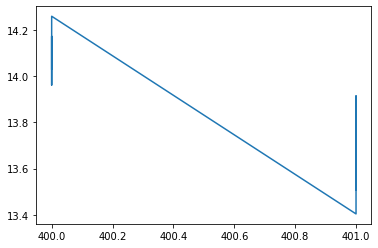

Training loss (for one batch) at step 40: nan


KeyboardInterrupt: ignored

In [ ]:
random_out = model(X[0:3,:,:,:],Y[0:3])
loss_log = []
epochs = 50
reg_coef = 1.0
file_name = '/content/drive/MyDrive/Arcface/checkpoint/my_checkpoint'
file_number = 0
log_data = open('/content/drive/MyDrive/Arcface/log_data.txt', 'r')
text_data = log_data.read()
log_data.close()
file_number = int(text_data[-2])
print(file_number)
model.load_weights(file_name + '_full_model' + str(file_number)+ '.h5')


for save_wt in range (0, 5):
  for epoch in range(epochs):
      print("\nStart of epoch %d" % (epoch,))
      start_time = time.time()

      # Iterate over the batches of the dataset.
      for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
          accuracy, train_loss, inference_loss, regularization_loss = train_step(x_batch_train, y_batch_train)
          #if epoch % 10 == 0:
          if step % 20 == 0: 
            loss_log.append([float(train_loss), (file_number + 1)*50 + epoch])
            clear_output(wait=True)  
            temp_var = np.array(loss_log)
            plt.plot(temp_var[:, 1], temp_var[:, 0])
  
            plt.show()                                                                                # Log every 20 batches.
            print("Training loss (for one batch) at step %d: %.4f"% (step, float(train_loss)))
            #print("Seen so far: %d samples" % ((step + 1) * hypar.batch_size))

            #print("Training acc over epoch: %.4f" % (float(accuracy)))

            #print("Time taken: %.2fs" % (time.time() - start_time))
            
      
  file_number += 1
  model.save_weights(file_name + '_full_model' + str(file_number)+ '.h5')
n_epoch = (file_number + 1)*50
log_data = open('/content/drive/MyDrive/Arcface/log_data.txt', 'a')
log_data.write('No of epoch till now : ' + str(n_epoch) + ', File number for record : ' + str(file_number) + '\n')
log_data.close()

In [ ]:
loss_log_data = np.array(loss_log)
np.save('/content/drive/MyDrive/Arcface/log/loss_log_400.npy', loss_log_data)

In [ ]:
test_model = model.resnet
result = test_model.predict(X)
result.shape

In [ ]:
index = []
for i in range (0,1470):
    if Y[i] == 25:
        index.append(i)

In [ ]:
index

[0,
 6,
 26,
 44,
 162,
 163,
 165,
 251,
 253,
 364,
 398,
 399,
 461,
 494,
 507,
 518,
 524,
 583,
 730,
 789,
 863,
 877,
 991,
 1002,
 1041,
 1051,
 1068,
 1158,
 1178,
 1184,
 1308,
 1415]

In [ ]:
a = np.dot(results[0,:], np.array(results[1415,:]).T)
print(a)

0.53175443


In [ ]:
a

0.009753675

In [ ]:
from sklearn.preprocessing import normalize
results = normalize(result, axis = 0)
results.shape

In [ ]:
result[0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([146799.23], dtype=float32)>